# **Energy Consumption Analysis**

- **Dataset**: The dataset contains hourly electricity load (in MW) for AEP (American Electric Power) with timestamps.


## 1. Install Libraries & Define Functions

(Note: When running the below code, if error persists, restarting the session and run again.)

In [1]:
!pip install -qq numpy==1.24.4
!pip install -qq pmdarima==2.0.3
!pip install -qq arch
!pip install -qq pyod

# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import kagglehub
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.express import line
import seaborn as sns
from pyod.models.ecod import ECOD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima
from arch.unitroot import ADF
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def acf_pacf(df, lag):
  # ACF & PACF Plots
  fig, ax = plt.subplots(1, 2, figsize=(15, 7))
  sm.graphics.tsa.plot_acf(df, title="ACF", lags=lag,ax=ax[0])
  sm.graphics.tsa.plot_pacf(df, title="PACF", lags=lag,ax=ax[1])
  plt.show()

def adf(data, trend='n', method='bic'):
  adf_result = ADF(data, trend=trend, method=method)  # Perform ADF test on the data
  print('Augmented Dickey-Fuller Unit Root Test:\n')  # Print test statistics and critical values
  return adf_result  # Return the result of the ADF test

# Define function for 4-season classification
def categorize_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Classify each hour into a time-based category
def classify_hour(hour):
    if 0 <= hour <= 4:
        return "Off_Peak_Night"
    elif 5 <= hour <= 9:
        return "Morning_Surge"
    elif 10 <= hour <= 16:
        return "Daytime_Stable"
    elif 17 <= hour <= 20:
        return "Evening_Peak"
    else:
        return "Transition"

# Define the mapping function
def month_number_to_name(month_num):
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return month_names[month_num - 1]

## 2. Import Data

In [35]:
# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

# List Available Files
files = os.listdir(path)
print("Available files:", files)

#  Load a CSV File into a DataFrame
hourly_energy_consumption = pd.read_csv(os.path.join(path, "AEP_hourly.csv"))

# Convert the first column to datetime
hourly_energy_consumption['Datetime'] = pd.to_datetime(hourly_energy_consumption['Datetime'])

# Set the datetime column as the index
hourly_energy_consumption = hourly_energy_consumption.set_index('Datetime')

# Display the first few rows
print(hourly_energy_consumption.head(10))

print('Data Information:')
print(hourly_energy_consumption.info())

print('\n Missing Values:')
print(hourly_energy_consumption.isnull().sum())

print('\n Statistical properties:')
print(hourly_energy_consumption.describe())

Available files: ['est_hourly.paruqet', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DUQ_hourly.csv', 'DAYTON_hourly.csv', 'PJME_hourly.csv', 'PJM_Load_hourly.csv', 'NI_hourly.csv', 'FE_hourly.csv', 'COMED_hourly.csv', 'AEP_hourly.csv', 'pjm_hourly_est.csv', 'DEOK_hourly.csv', 'PJMW_hourly.csv']
                      AEP_MW
Datetime                    
2004-12-31 01:00:00  13478.0
2004-12-31 02:00:00  12865.0
2004-12-31 03:00:00  12577.0
2004-12-31 04:00:00  12517.0
2004-12-31 05:00:00  12670.0
2004-12-31 06:00:00  13038.0
2004-12-31 07:00:00  13692.0
2004-12-31 08:00:00  14297.0
2004-12-31 09:00:00  14719.0
2004-12-31 10:00:00  14941.0
Data Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB
None

 Missing Values:
AEP_MW    0
dtype: int6

## 3. Exploratory Data Analysis

### 3.A Data Visualization



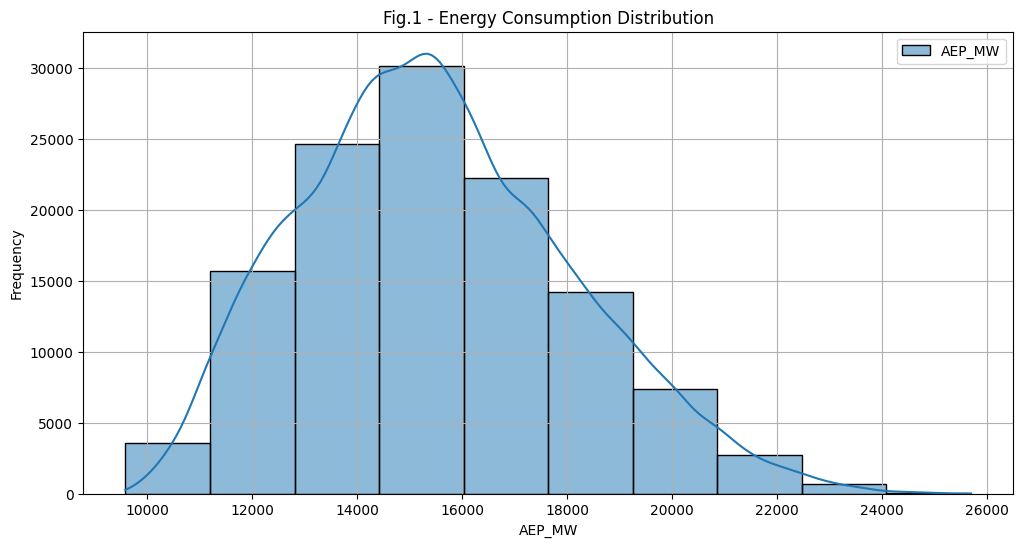

In [36]:
# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.histplot(hourly_energy_consumption, kde=True, color='skyblue', bins=10)
plt.title('Fig.1 - Energy Consumption Distribution')
plt.xlabel('AEP_MW')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

As can be observed in Fig. 1, the distribution of Energy Consumption in America exhibits a right-skewed pattern, indicating that a majority of the observations are concentrated on the lower end, with a long tail stretching towards higher values.

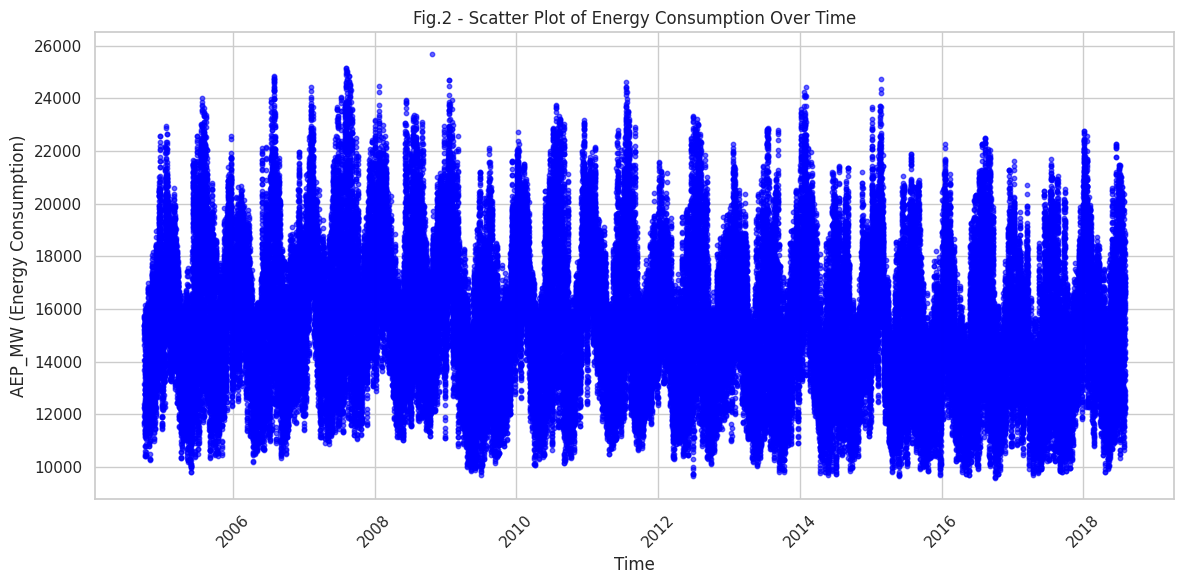

In [37]:
# Set the style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(hourly_energy_consumption.index, hourly_energy_consumption['AEP_MW'],
            s=10, alpha=0.6, color='blue')

# Labels and title
plt.title('Fig.2 - Scatter Plot of Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('AEP_MW (Energy Consumption)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

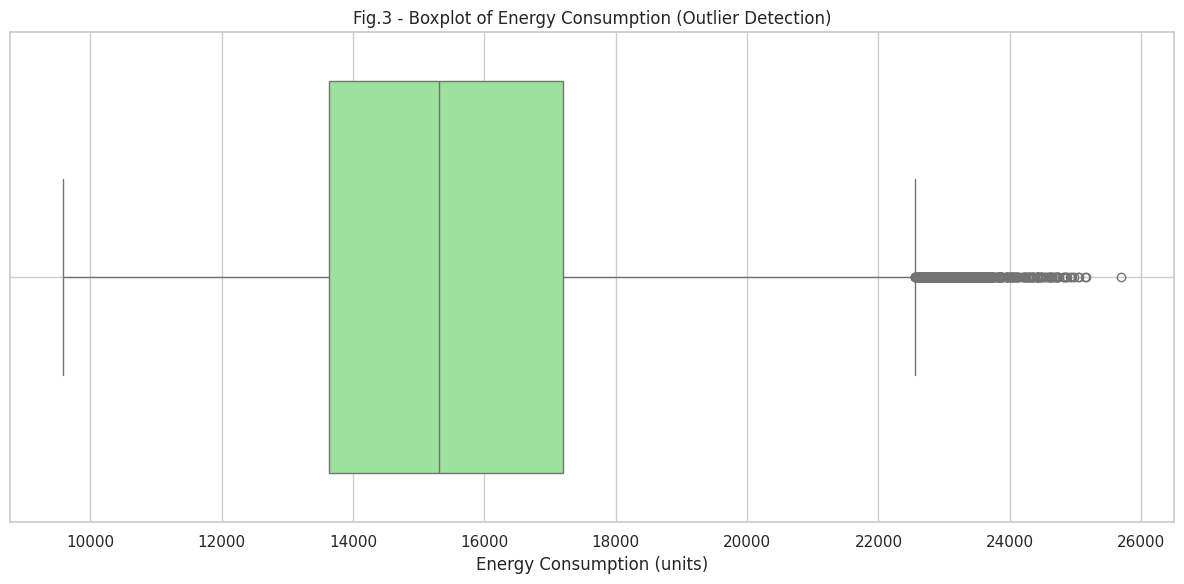

In [6]:
# Boxplot Visualize Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=hourly_energy_consumption['AEP_MW'], color='lightgreen')
plt.title('Fig.3 - Boxplot of Energy Consumption (Outlier Detection)')
plt.xlabel('Energy Consumption (units)')
plt.grid(True)
plt.tight_layout()
plt.show()

High consumption outliers may result from extreme weather conditions causing spikes in heating or cooling usage. Low outliers could reflect sudden drops in demand during holidays, maintenance outages, or nighttime off-peak hours.




### 3B. Data Cleaning

According to the initial inspection, it can be observed that the timestamps are not in correct orders.





In [41]:
# Create expected hourly timestamps from start to end
expected_index = pd.date_range(start=hourly_energy_consumption.index.min(),
                               end=hourly_energy_consumption.index.max(),
                               freq='H')

# Drop duplicate timestamps and reindex to expected hourly index
hourly_energy_consumption = hourly_energy_consumption[~hourly_energy_consumption.index.duplicated()].reindex(expected_index)

# Filter rows with missing values and interpolate
missing_rows = hourly_energy_consumption[hourly_energy_consumption.isna().any(axis=1)]
hourly_energy_consumption.interpolate(method='time', inplace=True)

# Print missing rows before interpolation
print(f"Missing rows before interpolation: \n{missing_rows}")

# Retrieve interpolated rows (where missing values were filled)
interpolated_rows = hourly_energy_consumption.loc[missing_rows.index]
print(f"Interpolated rows: \n{interpolated_rows}")

Missing rows before interpolation: 
                     AEP_MW Date  Hour  Month
2004-10-31 02:00:00     NaN  NaN   NaN    NaN
2005-04-03 03:00:00     NaN  NaN   NaN    NaN
2005-10-30 02:00:00     NaN  NaN   NaN    NaN
2006-04-02 03:00:00     NaN  NaN   NaN    NaN
2006-10-29 02:00:00     NaN  NaN   NaN    NaN
2007-03-11 03:00:00     NaN  NaN   NaN    NaN
2007-11-04 02:00:00     NaN  NaN   NaN    NaN
2008-03-09 03:00:00     NaN  NaN   NaN    NaN
2008-11-02 02:00:00     NaN  NaN   NaN    NaN
2009-03-08 03:00:00     NaN  NaN   NaN    NaN
2009-11-01 02:00:00     NaN  NaN   NaN    NaN
2010-03-14 03:00:00     NaN  NaN   NaN    NaN
2010-11-07 02:00:00     NaN  NaN   NaN    NaN
2010-12-10 00:00:00     NaN  NaN   NaN    NaN
2011-03-13 03:00:00     NaN  NaN   NaN    NaN
2011-11-06 02:00:00     NaN  NaN   NaN    NaN
2012-03-11 03:00:00     NaN  NaN   NaN    NaN
2012-11-04 02:00:00     NaN  NaN   NaN    NaN
2012-12-06 04:00:00     NaN  NaN   NaN    NaN
2013-03-10 03:00:00     NaN  NaN   NaN    Na

### 3C. Trend Analysis



In [42]:
# Create Date and Hour columns
hourly_energy_consumption['Date'] = hourly_energy_consumption.index.date
hourly_energy_consumption['Hour'] = hourly_energy_consumption.index.hour
hourly_energy_consumption['Month'] = hourly_energy_consumption.index.month

**I. Hourly Trend**

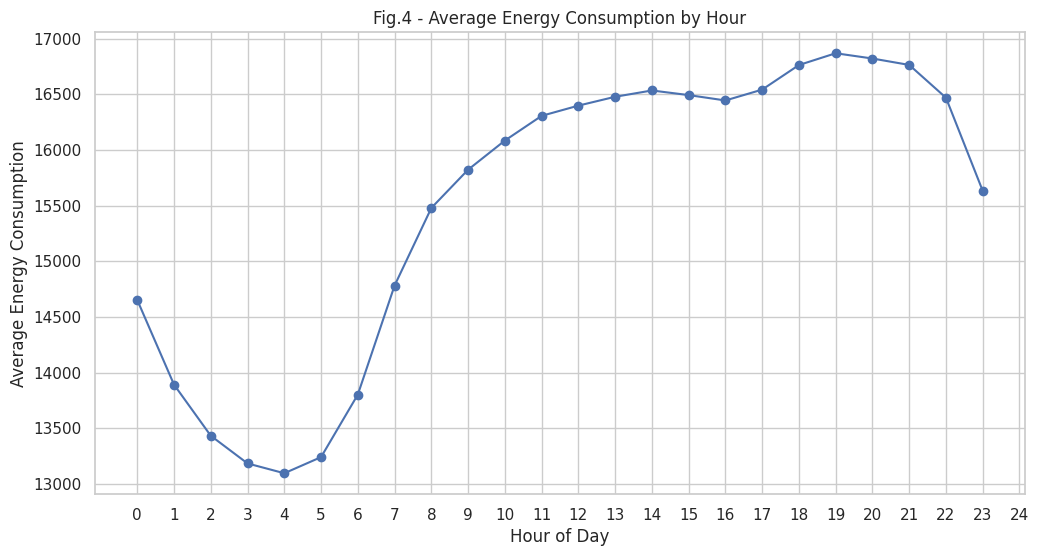

In [43]:
# Hourly Energy Consumption Pattern
hourly_avg = hourly_energy_consumption.groupby('Hour')['AEP_MW'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linestyle='-', color='b')

# Set the title and labels
plt.title("Fig.4 - Average Energy Consumption by Hour")
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Consumption')

# Set x-ticks
plt.xticks(range(0, 25))  # Show ticks for every hour of the day (0-24)

# Show the plot
plt.show()

From Fig.4, it can be observed that there is a clear energy consumption trend. The below is intepretations on the trend based on the graph.

1. **Off-Peak Hours (10:00 PM – 5:00 AM):**  
   Energy consumption **declines significantly** beginning around 9:00 PM and continues to drop through the night. The **lowest levels** are recorded in the early morning hours (around 3:00–5:00 AM), which aligns with minimal residential and commercial activity.

2. **Morning Surge (5:00 AM – 10:00 AM):**  
   A **sharp increase** in energy usage begins around 5:00 AM as people start their day. This rise is likely due to increased use of appliances, lighting, and HVAC systems during morning routines and the opening of businesses.

3. **Daytime Plateau (10:00 AM – 5:00 PM):**  
   Energy consumption **remains elevated and relatively stable** throughout standard business hours. This suggests sustained demand from commercial, industrial, and institutional operations during the day.

4. **Evening Peak (5:00 PM – 9:00 PM):**  
   A **second peak** occurs during the evening as people return home, cook, engage in household activities, and use entertainment devices. This period marks the **highest residential energy demand** of the day.

5. **Transition to Off-Peak (9:00 PM – 10:00 PM):**  
   Starting around 9:00 PM, consumption **drops rapidly**, signaling the end of peak residential activity and the transition back into off-peak nighttime usage.

**II. Daily Trend**

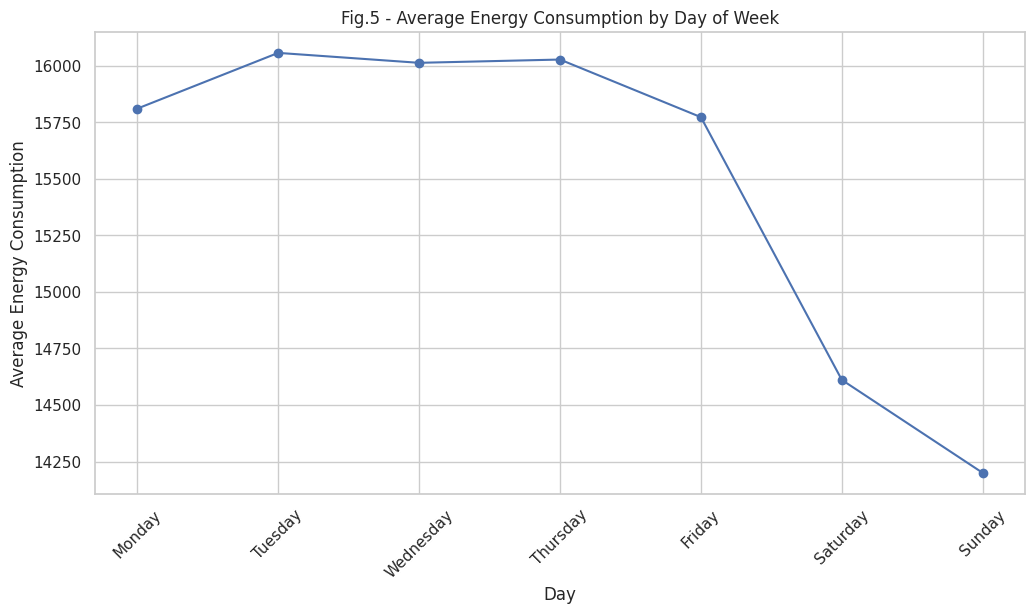

In [44]:
# Daily Energy Consumption Pattern
# Add a 'Day of Week' column
hourly_energy_consumption['Date'] = pd.to_datetime(hourly_energy_consumption['Date'])

# Add the 'Day of Week' column
hourly_energy_consumption['Day of Week'] = hourly_energy_consumption['Date'].apply(lambda x: x.strftime('%A'))
daily_avg = hourly_energy_consumption.groupby('Day of Week')['AEP_MW'].mean()

# Create an ordered list of days of the week
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reorganize the index based on the ordered days of the week
daily_avg = daily_avg.reindex(ordered_days)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_avg.index, daily_avg.values, marker='o', linestyle='-', color='b')

# Set the title and labels
plt.title("Fig.5 - Average Energy Consumption by Day of Week")
plt.xlabel('Day')
plt.ylabel('Average Energy Consumption')

# Set x-ticks to order days of the week correctly
plt.xticks(ticks=range(len(daily_avg.index)), labels=daily_avg.index, rotation=45)

# Show the plot
plt.show()

- Highest Power Consumption occurs on Tuesday (16057.62 MW), closely followed by Wednesday (16013.59 MW) and Thursday (16028.14 MW), indicating stable high values during the mid-week.

- The Lowest Power Consumption is observed on Sunday (14200.75 MW), followed by Saturday (14610.98 MW), suggesting lower demand or generation during the weekend.

- Monday (15810.97 MW) has slightly higher power generation than Friday (15773.12 MW), while Friday tends to show a minor drop in the data compared to earlier weekdays.

**III. Seasonality**

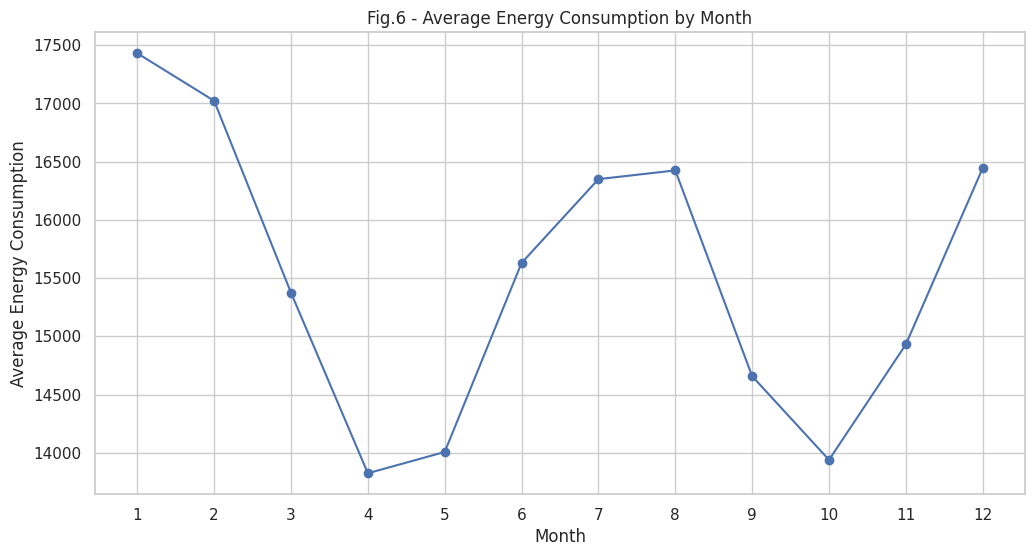

In [45]:
# Monthly Energy Consumption Trend
monthly_avg = hourly_energy_consumption.groupby('Month')['AEP_MW'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-', color='b')

# Set the title and labels
plt.title("Fig.6 - Average Energy Consumption by Month")
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption')

# Set x-ticks
plt.xticks(range(1, 13)) # 12 month

# Show the plot
plt.show()

Fig.6 exhibits clear seasonal variation, suggesting a strong relationship between **climate patterns** and **electricity usage**:

- **Winter Highs (Dec, Jan, Feb):**
  - January (17,431 MW), February (17,022 MW), and December (16,446 MW) show **the highest average consumption**, likely due to **increased heating demands** in colder months.
  
- **Summer Surge (June, July, August):**
  - June through August also show **elevated consumption**
  — June (15,630 MW), July (16,350 MW), August (16,425 MW) are likely driven by **air conditioning usage**.

- **Spring and Fall Dips (Mar–May, Sep–Nov):**
  - These transitional months show **lower average consumption**, with April (13,824 MW) and May (14,006 MW) reaching **yearly lows**. The reason is that the weather is mildly tolerable.

### 3.C Time Series Pre-processing

**I. Data Transformation**

In [9]:
# Create new exogs
hourly_energy_consumption["Usage_Class"] = hourly_energy_consumption['Hour'].map(classify_hour)
hourly_energy_consumption["Season"] = hourly_energy_consumption['Month'].apply(categorize_season)

# Apply it to the 'Month' column
hourly_energy_consumption['Month_Name'] = hourly_energy_consumption['Month'].apply(month_number_to_name)

# Endogeneous
df_hourly = pd.DataFrame({
    'AEP_MW': hourly_energy_consumption['AEP_MW']
}, index=hourly_energy_consumption.index)

In [10]:
# One-hot encode
dow_dummies_day = pd.get_dummies(hourly_energy_consumption['Day of Week'], drop_first=False).astype(int)
dow_dummies_month = pd.get_dummies(hourly_energy_consumption['Month_Name'], drop_first=False).astype(int)
dow_dummies_season = pd.get_dummies(hourly_energy_consumption['Season'], drop_first=False).astype(int)

# Combine both
exog_hourly = pd.concat([dow_dummies_day, dow_dummies_month, dow_dummies_season], axis=1)
exog_hourly.head(5)

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr,Aug,Dec,...,Jun,Mar,May,Nov,Oct,Sep,Fall,Spring,Summer,Winter
2004-10-01 01:00:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2004-10-01 02:00:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2004-10-01 03:00:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2004-10-01 04:00:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2004-10-01 05:00:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


**II. Stationary** (Correct the text)

In [15]:
# Perform the ADF test without Trend and Drift
adf(df_hourly['AEP_MW'], trend='n', method='bic')

Augmented Dickey-Fuller Unit Root Test:



Test Statistic,-2.022
P-value,0.041
Lags,71


- The test statistic (-2.022) is lower than all the critical value at the 5%, and 10% levels.

- The p-value (0.041) is lower than 0.05, indicating that there is an evidence to reject the null hypothesis.

- Under the specification without trend or drift, the test provides strong evidence of stationarity. The null hypothesis can be rejected, implying that the series is likely stationary.

In [46]:
# Perform the ADF test with Drift but without Trend
adf(df_hourly['AEP_MW'], trend='c', method='bic')

Augmented Dickey-Fuller Unit Root Test:



Test Statistic,-18.247
P-value,0.000
Lags,71


The test statistic (-18.247) is much more negative than the critical values at all significance levels (1%, 5%, 10%). This strongly supports rejecting the null hypothesis. The series appears to be stationary with drift (no trend), meaning it doesn’t contain a unit root and does not exhibit a systematic trend over time.

In [47]:
# Perform the ADF test with Trend and Drift
adf(df_hourly['AEP_MW'], trend='ct', method='bic')

Augmented Dickey-Fuller Unit Root Test:



Test Statistic,-18.979
P-value,0.000
Lags,71


With a test statistic of -18.979 and a p-value of 0.000, there is strong evidence to reject the null hypothesis. The series appears to be stationary even with the presence of both drift and a linear time trend.

**III. Data Splitting**

Due to the big size of dataset, the following code extracts a portion of data for further analysis.

In [11]:
# Define the time range
start_date = pd.Timestamp('2016-08-01 00:00:00')

# Extract data
filtered_df = df_hourly[(df_hourly.index >= start_date)]
filtered_exog = exog_hourly[(exog_hourly.index >= start_date)]

print(f"Filtered size: {len(filtered_df)}")
print(f"Filtered Exog size: {len(filtered_exog)}")

Filtered size: 17569
Filtered Exog size: 17569


In [12]:
# Define split point
train_size = int(len(filtered_df) * 0.8)
train, test = filtered_df[:train_size], filtered_df[train_size:]
exog_train = filtered_df[:train_size]

print(f"Training set size: {len(train)}")
print(f"Training Exog set size: {len(exog_train)}")
print(f"Test set size: {len(test)}")

Training set size: 14055
Training Exog set size: 14055
Test set size: 3514


## 4. Model Selection

**I. Parameters Selection**

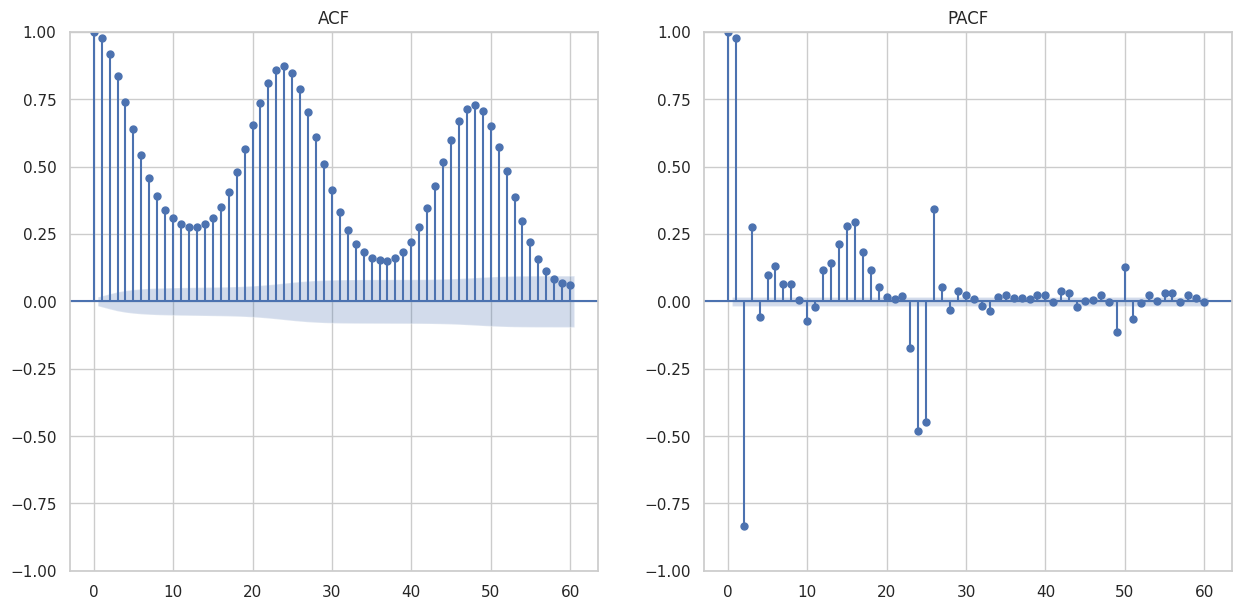

In [27]:
# Plot acf and pacf
acf_pacf(train, 60)

The ACF and PACF doesn't help that much to determine the appropriate lags in an ARIMA model; therefore, implementing `auto_arima` (without seasonal components) is helpful to obtain the right parameters. [Click the link for correct setting of `m`](https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period)

In [28]:
# Fit the auto_arima model
model_auto_selection = auto_arima(
    train,
    start_p = 0,
    start_d = 0,
    start_q = 0,
    max_p = 3,
    max_d = 3,
    max_q = 3,
    trace=True,
    with_intercept=False,
    return_valid_fits=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=215583.309, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=200305.000, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=204479.292, Time=5.85 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=198395.878, Time=2.49 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=198397.716, Time=2.50 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=197257.124, Time=11.57 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=198573.498, Time=1.98 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=198384.164, Time=3.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=196723.696, Time=12.96 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=198467.944, Time=4.99 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=196675.303, Time=23.84 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=195678.692, Time=22.10 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=196610.873, Time=9.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=195680.772, Time=60.32 sec


**II. Fitting the parameters to ARIMA & SARIMAX to the train data**

In [13]:
# ARIMA
warnings.filterwarnings("ignore")
model = ARIMA(train, order=(3, 1, 3), trend='n')
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:                14055
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -97832.346
Date:                Thu, 17 Apr 2025   AIC                         195678.692
Time:                        10:08:11   BIC                         195731.546
Sample:                    08-01-2016   HQIC                        195696.284
                         - 03-09-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4394      0.010    240.811      0.000       2.419       2.459
ar.L2         -1.9934      0.019   -103.040      0.000      -2.031      -1.955
ar.L3          0.5239      0.010     52.092      0.0

**Note**: The below code couldn't train on the entire train dataset because of RAM limitation.

In [14]:
# SARIMAX with seasonality component
best_model_sarimax = SARIMAX(
    endog=train,
    exogenous=exog_train,
    order=(3,1,3),
    seasonal_order=(1,1,1,24), # original 1,1,1,24
    suppress_warnings=True
).fit()

# Model summary
print(best_model_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               AEP_MW   No. Observations:                14055
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 24)   Log Likelihood              -90577.054
Date:                              Thu, 17 Apr 2025   AIC                         181172.109
Time:                                      10:11:19   BIC                         181240.049
Sample:                                  08-01-2016   HQIC                        181194.725
                                       - 03-09-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0772      0.115     -0.670      0.503      -0.303       0.149
ar.L2         -0.51

 ## 5. Diagnostic Checking

 **I. ARIMA**

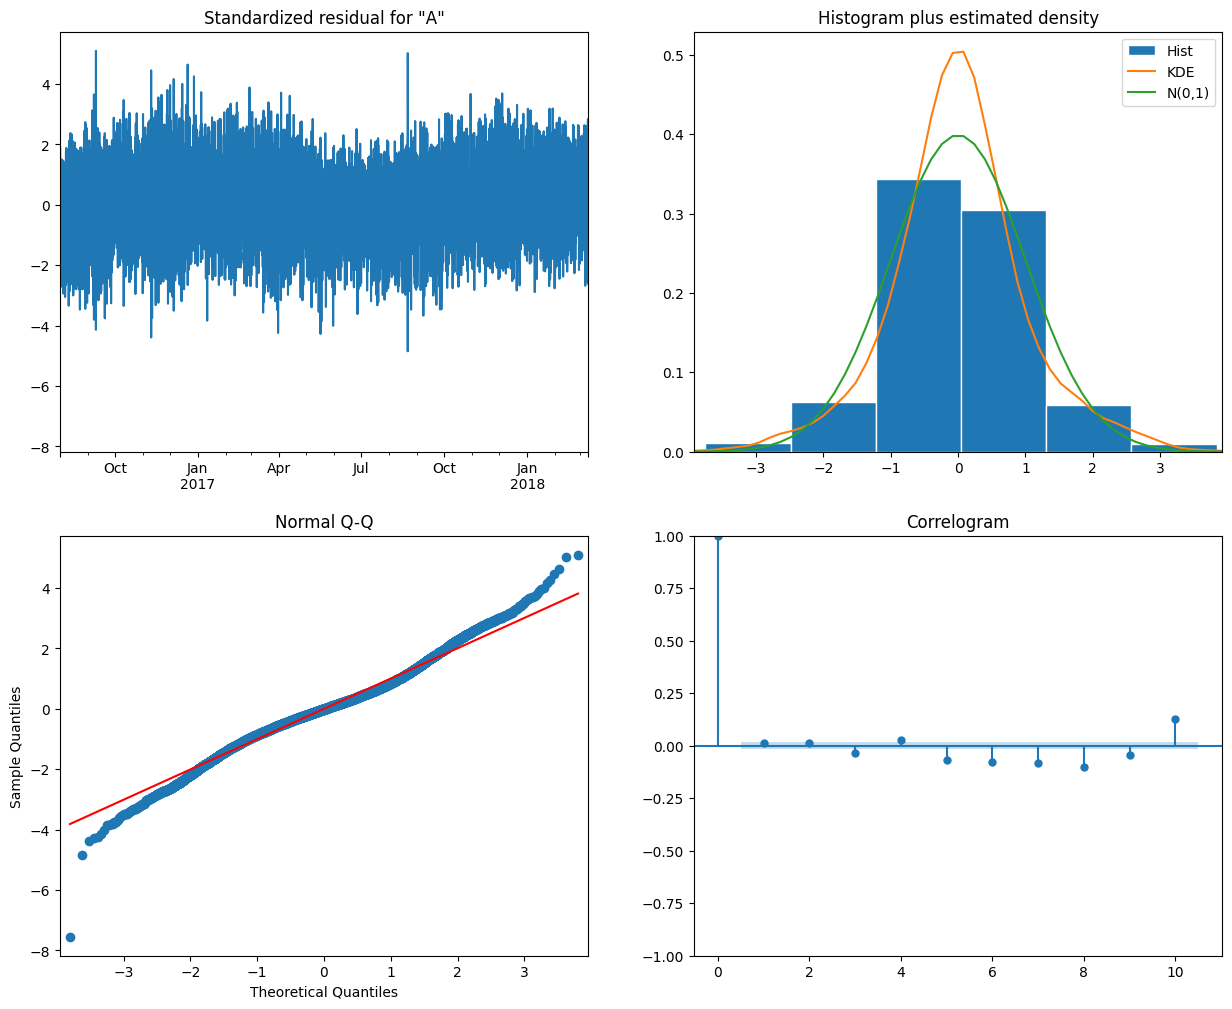

In [15]:
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

**Standardized Residuals:** The residuals does not appear to be constant.

**Histogram + KDE Estimate:** The distribution of residuals does not closely follow a normal distribution, as evidenced by the Kernel Density Estimate (KDE) curve, which is taller than the theoretical N(0,1) bell curve.

**Normal Q-Q Plot:** The residuals do not form a straight line on the diagonal line, some deviations are observed at the tails.

**Correlogram (ACF Plot):** The majority of autocorrelations do not lie within the 95% confidence bounds.


**II. SARIMAX with seasonal components**

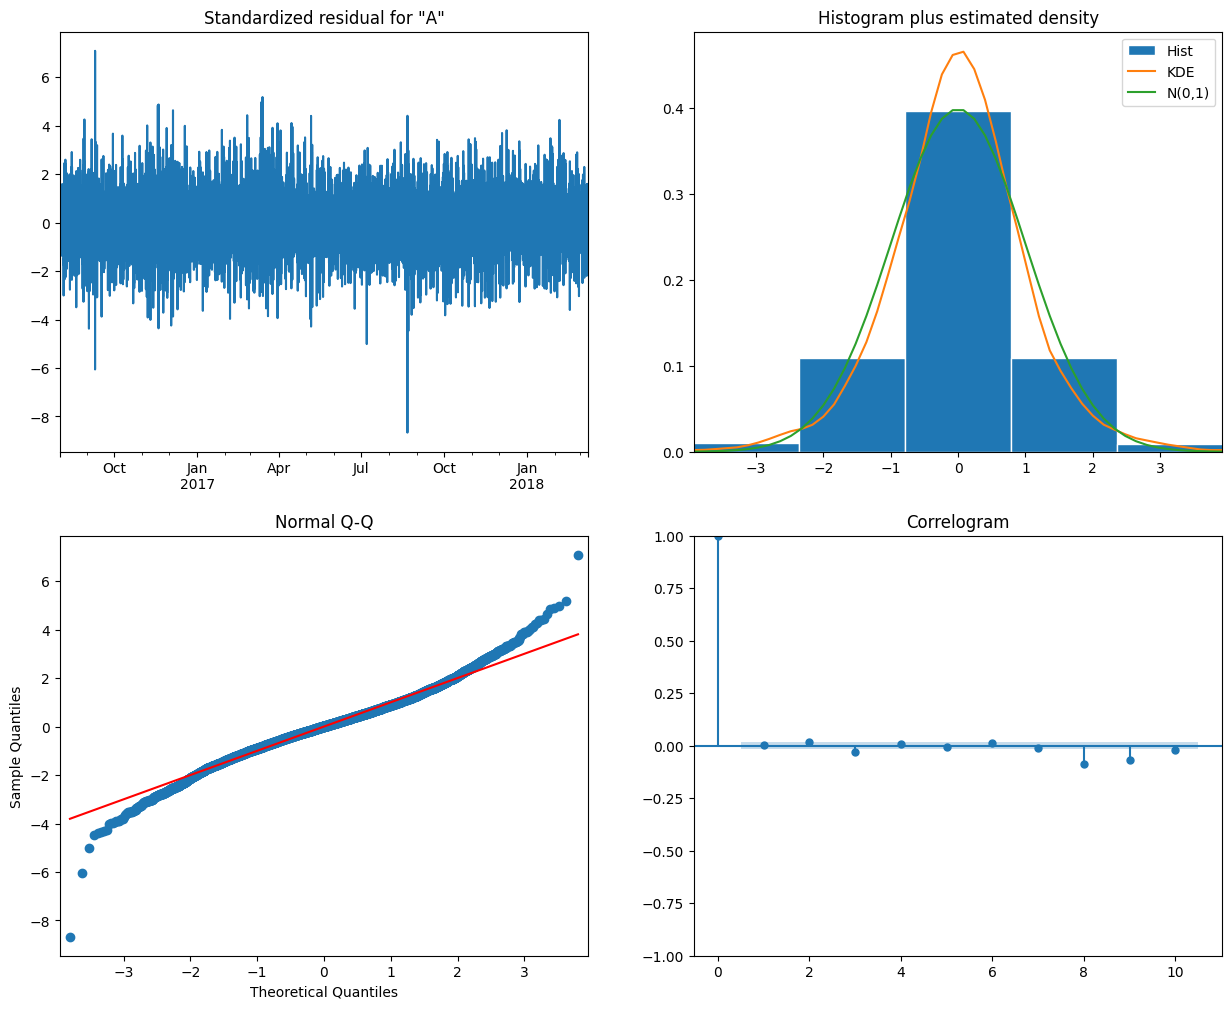

In [16]:
best_model_sarimax.plot_diagnostics(figsize=(15,12))
plt.show()

Adding the seasonal component (SARIMAX) significantly improved the model's performance over the non-seasonal ARIMA, as confirmed by residual diagnostics. The residuals are more stable, normally distributed, and fall within the expected confidence bands, indicating a better model fit and more reliable forecasts.

## 6. Model Evaluation

**I. ARIMA**

In [30]:
# Forecast future values
forecast_steps = 24
forecast = model_fit.get_forecast(steps=forecast_steps)

# Extract predicted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Evaluation metrics
mae = mean_absolute_error(test.iloc[:forecast_steps], forecast_values)
rmse = np.sqrt(mean_squared_error(test.iloc[:forecast_steps], forecast_values))
r2 = r2_score(test.iloc[:forecast_steps], forecast_values)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 1083.60
RMSE: 1383.42
R² Score: -3.5118


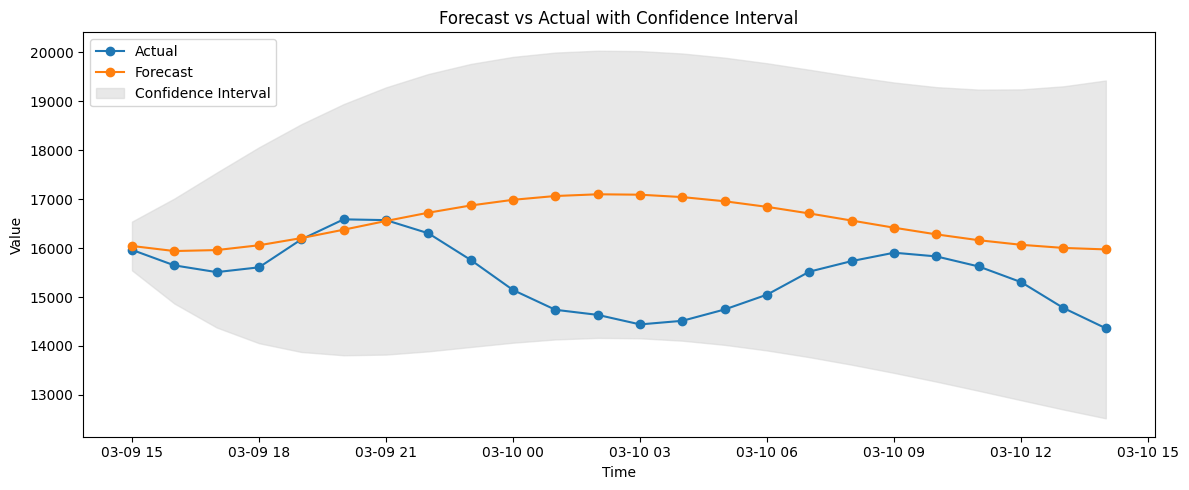

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(test.iloc[:forecast_steps], label='Actual', marker='o')
plt.plot(forecast_values, label='Forecast', marker='o')
plt.fill_between(forecast_values.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='lightgray', alpha=0.5, label='Confidence Interval')
plt.title('Forecast vs Actual with Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

**II. SARIMAX**

In [32]:
# Forecast future values
forecast_sarimax = best_model_sarimax.get_forecast(steps=forecast_steps)

# Extract predicted values and confidence intervals
forecast_values = forecast_sarimax.predicted_mean
forecast_conf_int = forecast_sarimax.conf_int()

# Evaluation metrics
mae = mean_absolute_error(test.iloc[:forecast_steps], forecast_values)
rmse = np.sqrt(mean_squared_error(test.iloc[:forecast_steps], forecast_values))
r2 = r2_score(test.iloc[:forecast_steps], forecast_values)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 505.95
RMSE: 728.62
R² Score: -0.2516


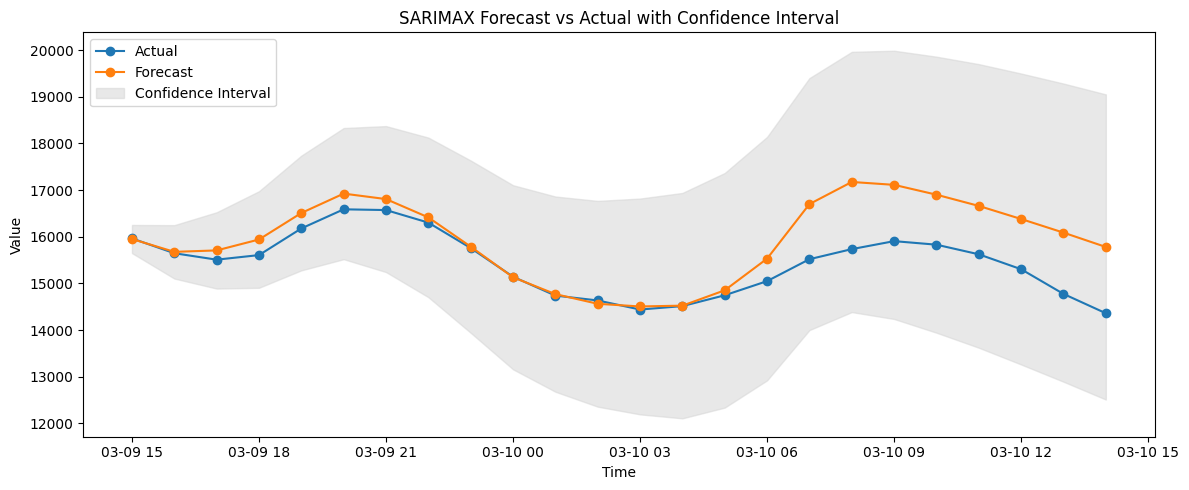

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(test.iloc[:forecast_steps], label='Actual', marker='o')
plt.plot(forecast_values, label='Forecast', marker='o')
plt.fill_between(forecast_values.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='lightgray', alpha=0.5, label='Confidence Interval')
plt.title('SARIMAX Forecast vs Actual with Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()